U-Net 3D 

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.ndimage as ndi
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

🖥️ Device: cpu


In [3]:
DATASET_PATH = r"C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus" 
PREPROCESSED_PATH = os.path.join(DATASET_PATH, "preprocessed")
RESULTS_PATH = os.path.join(DATASET_PATH, "results")
RESULTS_3D_PATH = os.path.join(RESULTS_PATH, "3d_experiments")
os.makedirs(RESULTS_3D_PATH, exist_ok=True)

print(f"✅ Configuration prête!")
print(f"📁 Résultats 3D: {RESULTS_3D_PATH}")

✅ Configuration prête!
📁 Résultats 3D: C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus\results\3d_experiments


 Charger les informations de split

In [4]:
with open(os.path.join(PREPROCESSED_PATH, 'split_info.json'), 'r') as f:
    split_info = json.load(f)

train_files = split_info['train']
val_files = split_info['val']
target_size = tuple(split_info['target_size'])

print(f" DONNÉES:")
print(f"  Train: {len(train_files)} volumes")
print(f"  Validation: {len(val_files)} volumes")
print(f"  Taille: {target_size}")

 DONNÉES:
  Train: 208 volumes
  Validation: 52 volumes
  Taille: (64, 64, 64)


Dataset 3D (volumes entiers)

In [5]:
class HippocampusDataset3D(Dataset):
    """
    Dataset 3D: charge les volumes 3D complets
    
    Args:
        file_list: liste des fichiers
        preprocessed_path: chemin vers les données preprocessées
        split: 'train' ou 'val'
        augment: bool, appliquer augmentation ou non
    """
    def __init__(self, file_list, preprocessed_path, split='train', augment=False):
        self.file_list = file_list
        self.preprocessed_path = preprocessed_path
        self.split = split
        self.augment = augment
        
        # Liste des volumes
        self.volumes = []
        for file_info in file_list:
            base_name = file_info['image'].replace('.nii.gz', '')
            img_path = os.path.join(preprocessed_path, split, f"{base_name}_img.npy")
            lbl_path = os.path.join(preprocessed_path, split, f"{base_name}_lbl.npy")
            
            if os.path.exists(img_path) and os.path.exists(lbl_path):
                self.volumes.append({
                    'image': img_path,
                    'label': lbl_path
                })
        
        print(f"  {split}: {len(self.volumes)} volumes 3D")
    
    def __len__(self):
        return len(self.volumes)
    
    def __getitem__(self, idx):
        volume_info = self.volumes[idx]
        
        # Charger le volume 3D
        image = np.load(volume_info['image'])
        label = np.load(volume_info['label'])
        
        # Augmentation 3D (si activée)
        if self.augment:
            # Flip aléatoire
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=0).copy()
                label = np.flip(label, axis=0).copy()
            
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=1).copy()
                label = np.flip(label, axis=1).copy()
            
            # Rotation aléatoire (autour de l'axe Z)
            if np.random.rand() > 0.7:
                angle = np.random.uniform(-10, 10)
                image = ndi.rotate(image, angle, axes=(0, 1), reshape=False, order=1)
                label = ndi.rotate(label, angle, axes=(0, 1), reshape=False, order=0)
        
        # Convertir en tenseur
        image = torch.from_numpy(image).float().unsqueeze(0)  # (1, X, Y, Z)
        label = torch.from_numpy(label).long()  # (X, Y, Z)
        
        return image, label


# Créer les datasets
train_dataset_3d = HippocampusDataset3D(
    train_files,
    PREPROCESSED_PATH,
    split='train',
    augment=True
)

val_dataset_3d = HippocampusDataset3D(
    val_files,
    PREPROCESSED_PATH,
    split='val',
    augment=False
)

# DataLoaders (batch_size petit pour 3D !)
BATCH_SIZE_3D = 2  # Petit batch pour économiser mémoire

train_loader_3d = DataLoader(
    train_dataset_3d,
    batch_size=BATCH_SIZE_3D,
    shuffle=True,
    num_workers=0
)

val_loader_3d = DataLoader(
    val_dataset_3d,
    batch_size=BATCH_SIZE_3D,
    shuffle=False,
    num_workers=0
)

print(f"\n✅ DataLoaders 3D créés")
print(f"  Batch size: {BATCH_SIZE_3D}")
print(f"  Train batches: {len(train_loader_3d)}")
print(f"  Val batches: {len(val_loader_3d)}")

# Test
images, labels = next(iter(train_loader_3d))
print(f"\n🧪 Test:")
print(f"  Batch images: {images.shape}")  # (batch, 1, X, Y, Z)
print(f"  Batch labels: {labels.shape}")  # (batch, X, Y, Z)


  train: 208 volumes 3D
  val: 52 volumes 3D

✅ DataLoaders 3D créés
  Batch size: 2
  Train batches: 104
  Val batches: 26

🧪 Test:
  Batch images: torch.Size([2, 1, 64, 64, 64])
  Batch labels: torch.Size([2, 64, 64, 64])


Architecture U-Net 3D

In [6]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, base_filters=16):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block_3d(in_channels, base_filters)
        self.enc2 = self.conv_block_3d(base_filters, base_filters * 2)
        self.enc3 = self.conv_block_3d(base_filters * 2, base_filters * 4)
        self.enc4 = self.conv_block_3d(base_filters * 4, base_filters * 8)
        
        # Bottleneck
        self.bottleneck = self.conv_block_3d(base_filters * 8, base_filters * 16)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose3d(base_filters * 16, base_filters * 8, 2, stride=2)
        self.dec4 = self.conv_block_3d(base_filters * 16, base_filters * 8)
        
        self.upconv3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4, 2, stride=2)
        self.dec3 = self.conv_block_3d(base_filters * 8, base_filters * 4)
        
        self.upconv2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, 2, stride=2)
        self.dec2 = self.conv_block_3d(base_filters * 4, base_filters * 2)
        
        self.upconv1 = nn.ConvTranspose3d(base_filters * 2, base_filters, 2, stride=2)
        self.dec1 = self.conv_block_3d(base_filters * 2, base_filters)
        
        # Output
        self.out = nn.Conv3d(base_filters, num_classes, 1)
        
        # Max pooling 3D
        self.pool = nn.MaxPool3d(2)
    
    def conv_block_3d(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        return self.out(dec1)


# Créer le modèle
model_3d = UNet3D(in_channels=1, num_classes=3, base_filters=16).to(device)

# Test
test_input = torch.randn(1, 1, 64, 64, 64).to(device)
test_output = model_3d(test_input)

print(f"✅ U-Net 3D défini")
print(f"  Input: {test_input.shape}")
print(f"  Output: {test_output.shape}")
print(f"  Paramètres: {sum(p.numel() for p in model_3d.parameters()):,}")

# Comparer avec 2D
print(f"\n📊 COMPARAISON 2D vs 3D:")
print(f"  U-Net 2D (base_filters=32): ~1.9M paramètres")
print(f"  U-Net 3D (base_filters=16): {sum(p.numel() for p in model_3d.parameters()):,} paramètres")
print(f"  Note: 3D avec base_filters=16 ≈ complexité de 2D avec 32")

✅ U-Net 3D défini
  Input: torch.Size([1, 1, 64, 64, 64])
  Output: torch.Size([1, 3, 64, 64, 64])
  Paramètres: 5,647,891

📊 COMPARAISON 2D vs 3D:
  U-Net 2D (base_filters=32): ~1.9M paramètres
  U-Net 3D (base_filters=16): 5,647,891 paramètres
  Note: 3D avec base_filters=16 ≈ complexité de 2D avec 32


Loss Functions (même que 2D)


In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])
        target_one_hot = target_one_hot.permute(0, 4, 1, 2, 3).float()  # 3D!
        
        intersection = (pred * target_one_hot).sum(dim=(2, 3, 4))
        union = pred.sum(dim=(2, 3, 4)) + target_one_hot.sum(dim=(2, 3, 4))
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
    
    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        ce = self.ce_loss(pred, target)
        return self.weight_dice * dice + self.weight_ce * ce



Fonctions d'entraînement 3D

In [8]:
def dice_score_3d(pred, target, num_classes=3):
    """Calculer le Dice Score pour volumes 3D"""
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    
    dice_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        
        if union == 0:
            dice_scores.append(1.0)
        else:
            dice_scores.append((2.0 * intersection / union).item())
    
    return dice_scores


def train_epoch_3d(model, loader, criterion, optimizer, device):
    """Une epoch d'entraînement 3D"""
    model.train()
    total_loss = 0
    
    for images, labels in tqdm(loader, desc='Training 3D', leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def validate_3d(model, loader, criterion, device):
    """Validation 3D"""
    model.eval()
    total_loss = 0
    dice_scores_all = defaultdict(list)
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation 3D', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Dice score
            scores = dice_score_3d(outputs, labels)
            for i, score in enumerate(scores):
                dice_scores_all[f'class_{i}'].append(score)
    
    avg_dice = {k: np.mean(v) for k, v in dice_scores_all.items()}
    
    return total_loss / len(loader), avg_dice


print("✅ Fonctions d'entraînement 3D définies")

✅ Fonctions d'entraînement 3D définies


🧪 EXPÉRIENCE 3D-1 - U-Net 3D Baseline

In [9]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 3D-1: U-Net 3D Baseline + DiceLoss")
print("🧪" * 35)

# Configuration
NUM_EPOCHS_3D = 10
LEARNING_RATE_3D = 1e-4

exp3d1_config = {
    'name': 'EXP_3D1_Baseline_DiceLoss',
    'architecture': '3D U-Net',
    'augmentation': 'Flip + Rotation',
    'loss': 'DiceLoss',
    'base_filters': 16
}

# Modèle
model_3d1 = UNet3D(in_channels=1, num_classes=3, base_filters=16).to(device)
criterion_3d1 = DiceLoss()
optimizer_3d1 = optim.Adam(model_3d1.parameters(), lr=LEARNING_RATE_3D)

# Historique
history_3d1 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement 3D-1 ({NUM_EPOCHS_3D} epochs)...")
print(f"⚠️ Attention: L'entraînement 3D est BEAUCOUP plus lent que 2D!")

for epoch in range(NUM_EPOCHS_3D):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_3D}")
    
    # Train
    train_loss = train_epoch_3d(model_3d1, train_loader_3d, criterion_3d1, optimizer_3d1, device)
    history_3d1['train_loss'].append(train_loss)
    
    # Validation
    val_loss, val_dice = validate_3d(model_3d1, val_loader_3d, criterion_3d1, device)
    history_3d1['val_loss'].append(val_loss)
    history_3d1['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

# Sauvegarder
torch.save(model_3d1.state_dict(), os.path.join(RESULTS_3D_PATH, 'exp3d1_model.pth'))

print(f"\n✅ EXP 3D-1 terminée - Dice Score final: {avg_dice:.4f}")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 3D-1: U-Net 3D Baseline + DiceLoss
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement 3D-1 (10 epochs)...
⚠️ Attention: L'entraînement 3D est BEAUCOUP plus lent que 2D!

Epoch 1/10


  Train Loss: 0.7559 | Val Loss: 0.7274 | Avg Dice: 0.5699

Epoch 2/10


  Train Loss: 0.7197 | Val Loss: 0.7124 | Avg Dice: 0.6757

Epoch 3/10


  Train Loss: 0.7056 | Val Loss: 0.6977 | Avg Dice: 0.7137

Epoch 4/10


  Train Loss: 0.6940 | Val Loss: 0.6858 | Avg Dice: 0.7401

Epoch 5/10


  Train Loss: 0.6805 | Val Loss: 0.6734 | Avg Dice: 0.7191

Epoch 6/10


  Train Loss: 0.6672 | Val Loss: 0.6560 | Avg Dice: 0.7467

Epoch 7/10


  Train Loss: 0.6537 | Val Loss: 0.6517 | Avg Dice: 0.7839

Epoch 8/10


  Train Loss: 0.6395 | Val Loss: 0.6341 | Avg Dice: 0.7612

Epoch 9/10


  Train Loss: 0.6243 | Val Loss: 0.6204 | Avg Dice: 0.7655

Epoch 10/10


  Train Loss: 0.6081 | Val Loss: 0.6011 | Avg Dice: 0.7846

✅ EXP 3D-1 terminée - Dice Score final: 0.7846


🧪 EXPÉRIENCE 3D-2 - U-Net 3D avec Combined Loss

In [10]:
print("\n" + "🧪" * 35)
print("EXPÉRIENCE 3D-2: U-Net 3D + CombinedLoss")
print("🧪" * 35)

exp3d2_config = {
    'name': 'EXP_3D2_CombinedLoss',
    'architecture': '3D U-Net',
    'augmentation': 'Flip + Rotation',
    'loss': 'CombinedLoss',
    'base_filters': 16
}

# Modèle
model_3d2 = UNet3D(in_channels=1, num_classes=3, base_filters=16).to(device)
criterion_3d2 = CombinedLoss(weight_dice=0.7, weight_ce=0.3)
optimizer_3d2 = optim.Adam(model_3d2.parameters(), lr=LEARNING_RATE_3D)

# Historique
history_3d2 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement 3D-2 ({NUM_EPOCHS_3D} epochs)...")

for epoch in range(NUM_EPOCHS_3D):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_3D}")
    
    train_loss = train_epoch_3d(model_3d2, train_loader_3d, criterion_3d2, optimizer_3d2, device)
    history_3d2['train_loss'].append(train_loss)
    
    val_loss, val_dice = validate_3d(model_3d2, val_loader_3d, DiceLoss(), device)
    history_3d2['val_loss'].append(val_loss)
    history_3d2['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

torch.save(model_3d2.state_dict(), os.path.join(RESULTS_3D_PATH, 'exp3d2_model.pth'))

print(f"\n✅ EXP 3D-2 terminée - Dice Score final: {avg_dice:.4f}")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
EXPÉRIENCE 3D-2: U-Net 3D + CombinedLoss
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

📊 Entraînement 3D-2 (10 epochs)...

Epoch 1/10


  Train Loss: 1.0009 | Val Loss: 0.8234 | Avg Dice: 0.0805

Epoch 2/10


  Train Loss: 0.8972 | Val Loss: 0.8134 | Avg Dice: 0.1615

Epoch 3/10


  Train Loss: 0.8708 | Val Loss: 0.8018 | Avg Dice: 0.1927

Epoch 4/10


  Train Loss: 0.8507 | Val Loss: 0.7905 | Avg Dice: 0.2316

Epoch 5/10


  Train Loss: 0.8267 | Val Loss: 0.7837 | Avg Dice: 0.5317

Epoch 6/10


  Train Loss: 0.8069 | Val Loss: 0.7735 | Avg Dice: 0.5199

Epoch 7/10


  Train Loss: 0.7881 | Val Loss: 0.7674 | Avg Dice: 0.5083

Epoch 8/10


  Train Loss: 0.7674 | Val Loss: 0.7556 | Avg Dice: 0.5183

Epoch 9/10


  Train Loss: 0.7471 | Val Loss: 0.7500 | Avg Dice: 0.6132

Epoch 10/10


  Train Loss: 0.7281 | Val Loss: 0.7403 | Avg Dice: 0.8108

✅ EXP 3D-2 terminée - Dice Score final: 0.8108


Comparaison 2D vs 3D - Charger résultats 2D

In [11]:
print("\n" + "📊" * 35)
print("COMPARAISON 2D vs 3D")
print("📊" * 35)

# Charger le CSV des expériences 2D
csv_2d_path = os.path.join(RESULTS_PATH, 'experiments_comparison.csv')

if os.path.exists(csv_2d_path):
    df_2d = pd.read_csv(csv_2d_path)
    print(f"✅ Résultats 2D chargés:")
    print(df_2d[['Expérience', 'Augmentation', 'Loss Function', 'Final Avg Dice']])
    
    # Meilleur 2D
    best_2d = df_2d.loc[df_2d['Final Avg Dice'].idxmax()]
    print(f"\n🏆 Meilleur 2D:")
    print(f"  {best_2d['Expérience']}: Dice = {best_2d['Final Avg Dice']:.4f}")
else:
    print("⚠️ Fichier experiments_comparison.csv non trouvé")
    print("   Assurez-vous d'avoir exécuté le notebook 3 (2D) avant")
    best_2d_dice = 0.75  # Valeur par défaut pour comparaison


📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
COMPARAISON 2D vs 3D
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
✅ Résultats 2D chargés:
  Expérience     Augmentation             Loss Function  Final Avg Dice
0       EXP5  Flip + Rotation          CrossEntropyLoss        0.925607
1       EXP6  Flip + Rotation  CombinedLoss (Dice + CE)        0.920404

🏆 Meilleur 2D:
  EXP5: Dice = 0.9256


 Tableau comparatif 2D vs 3D

In [13]:
# Résultats 3D
results_3d = {
    'EXP_3D1': {
        'architecture': '3D U-Net',
        'augmentation': 'Flip + Rotation',
        'loss': 'DiceLoss',
        'final_dice': np.mean([v for v in history_3d1['val_dice'][-1].values()]),
        'params': sum(p.numel() for p in model_3d1.parameters())
    },
    'EXP_3D2': {
        'architecture': '3D U-Net',
        'augmentation': 'Flip + Rotation',
        'loss': 'CombinedLoss',
        'final_dice': np.mean([v for v in history_3d2['val_dice'][-1].values()]),
        'params': sum(p.numel() for p in model_3d2.parameters())
    }
}

# Créer DataFrame
comparison_3d_data = []
for exp_name, exp_data in results_3d.items():
    row = {
        'Expérience': exp_name,
        'Architecture': exp_data['architecture'],
        'Augmentation': exp_data['augmentation'],
        'Loss Function': exp_data['loss'],
        'Final Dice': exp_data['final_dice'],
        'Paramètres': f"{exp_data['params']:,}"
    }
    comparison_3d_data.append(row)

df_3d = pd.DataFrame(comparison_3d_data)

print("\n📋 RÉSULTATS 3D:")
print(df_3d.to_string(index=False))

# Sauvegarder
csv_3d_path = os.path.join(RESULTS_3D_PATH, 'experiments_3d_comparison.csv')
df_3d.to_csv(csv_3d_path, index=False)
print(f"\n✅ Sauvegardé: {csv_3d_path}")


📋 RÉSULTATS 3D:
Expérience Architecture    Augmentation Loss Function  Final Dice Paramètres
   EXP_3D1     3D U-Net Flip + Rotation      DiceLoss    0.784562  5,647,891
   EXP_3D2     3D U-Net Flip + Rotation  CombinedLoss    0.810797  5,647,891

✅ Sauvegardé: C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus\results\3d_experiments\experiments_3d_comparison.csv


Graphiques de comparaison 2D vs 3D

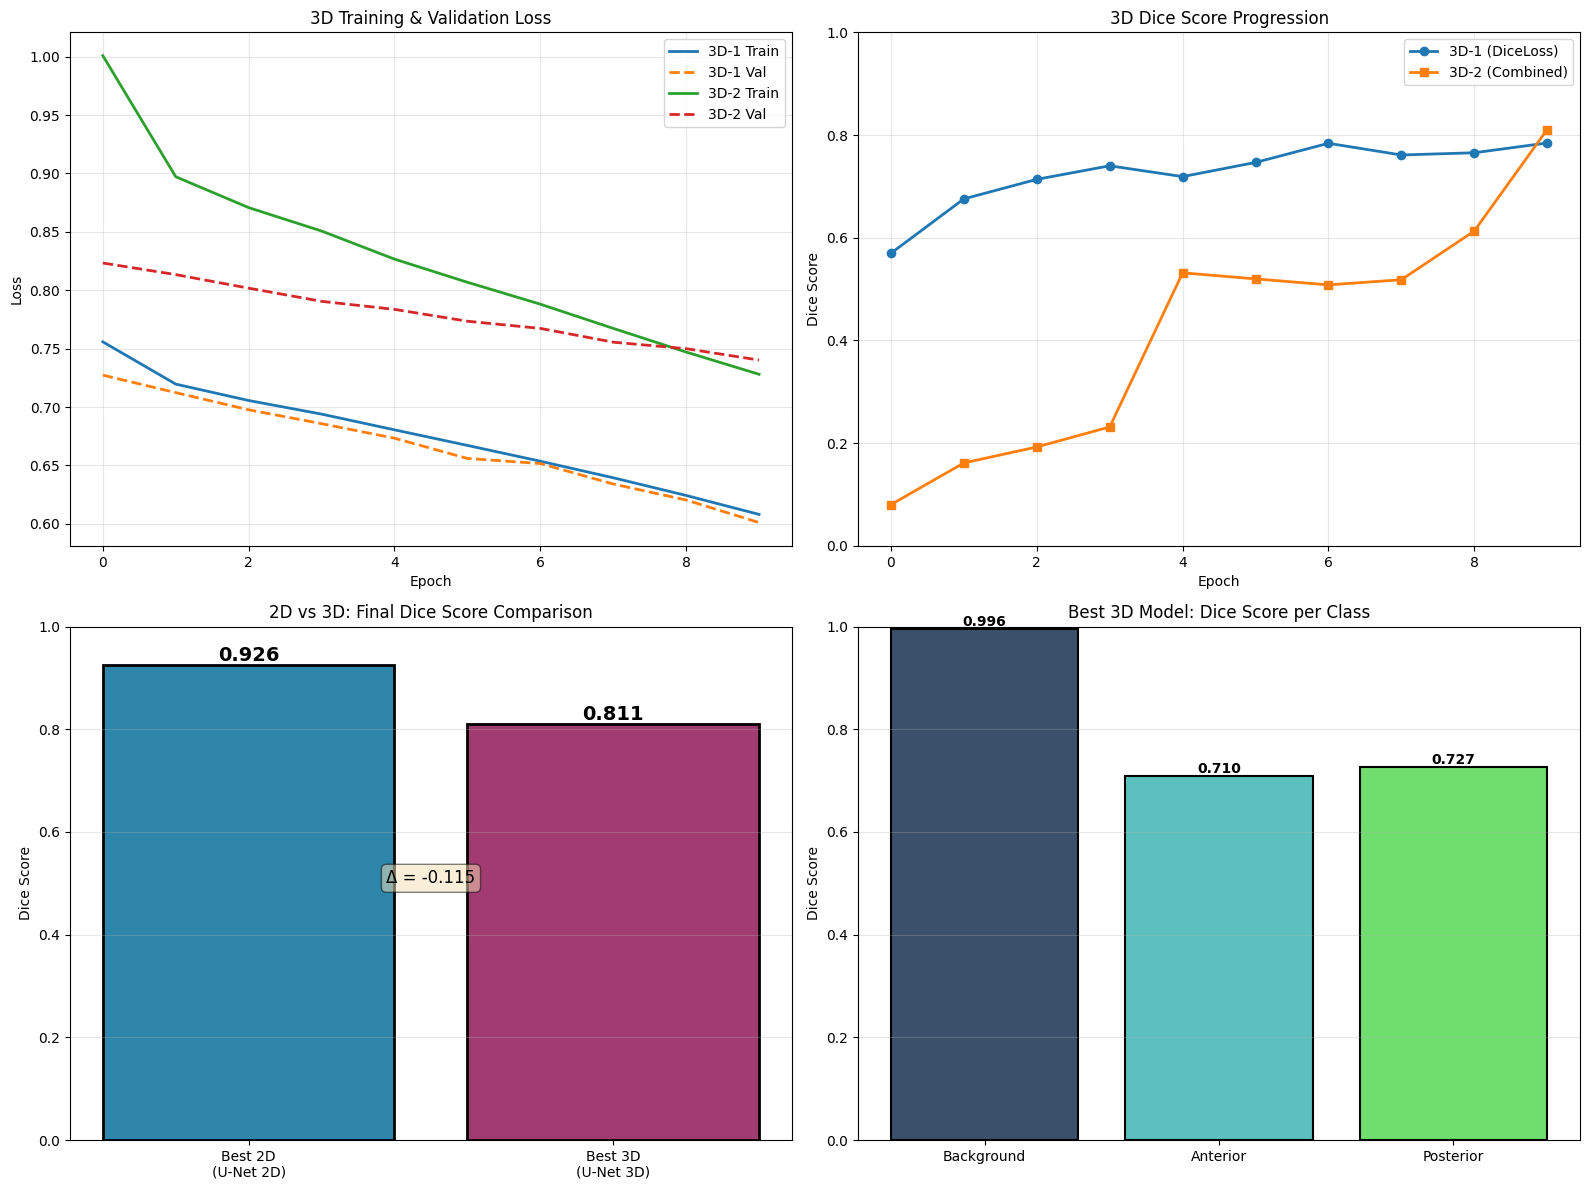


✅ Graphiques sauvegardés: 2d_vs_3d_comparison.png


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Courbes de loss (3D seulement)
ax1 = axes[0, 0]
ax1.plot(history_3d1['train_loss'], label='3D-1 Train', linewidth=2)
ax1.plot(history_3d1['val_loss'], label='3D-1 Val', linewidth=2, linestyle='--')
ax1.plot(history_3d2['train_loss'], label='3D-2 Train', linewidth=2)
ax1.plot(history_3d2['val_loss'], label='3D-2 Val', linewidth=2, linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('3D Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Dice Score progression (3D)
ax2 = axes[0, 1]
dice_3d1 = [np.mean(list(d.values())) for d in history_3d1['val_dice']]
dice_3d2 = [np.mean(list(d.values())) for d in history_3d2['val_dice']]
ax2.plot(dice_3d1, label='3D-1 (DiceLoss)', linewidth=2, marker='o')
ax2.plot(dice_3d2, label='3D-2 (Combined)', linewidth=2, marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Dice Score')
ax2.set_title('3D Dice Score Progression')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# 3. Comparaison finale 2D vs 3D (bar plot)
ax3 = axes[1, 0]

if os.path.exists(csv_2d_path):
    # Meilleurs résultats de chaque type
    best_2d_dice = best_2d['Final Avg Dice']
    best_3d_dice = max(dice_3d1[-1], dice_3d2[-1])
    
    categories = ['Best 2D\n(U-Net 2D)', 'Best 3D\n(U-Net 3D)']
    dice_scores = [best_2d_dice, best_3d_dice]
    colors = ['#2E86AB', '#A23B72']
    
    bars = ax3.bar(categories, dice_scores, color=colors, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Dice Score')
    ax3.set_title('2D vs 3D: Final Dice Score Comparison')
    ax3.set_ylim([0, 1])
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Valeurs sur les barres
    for bar, score in zip(bars, dice_scores):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{score:.3f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    # Différence
    diff = best_3d_dice - best_2d_dice
    ax3.text(0.5, 0.5, f'Δ = {diff:+.3f}', 
             transform=ax3.transAxes, ha='center', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Dice Score par classe (3D meilleur modèle)
ax4 = axes[1, 1]
best_3d_history = history_3d1 if dice_3d1[-1] > dice_3d2[-1] else history_3d2
final_dice_per_class = best_3d_history['val_dice'][-1]

classes = ['Background', 'Anterior', 'Posterior']
dice_per_class = [final_dice_per_class[f'class_{i}'] for i in range(3)]
colors_class = ['#3A506B', '#5BC0BE', '#6FDE6E']

bars = ax4.bar(classes, dice_per_class, color=colors_class, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Dice Score')
ax4.set_title('Best 3D Model: Dice Score per Class')
ax4.set_ylim([0, 1])
ax4.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, dice_per_class):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_3D_PATH, '2d_vs_3d_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Graphiques sauvegardés: 2d_vs_3d_comparison.png")

Visualisation des prédictions 3D


----------------------------------------------------------------------
VISUALISATION DES PRÉDICTIONS 3D
----------------------------------------------------------------------


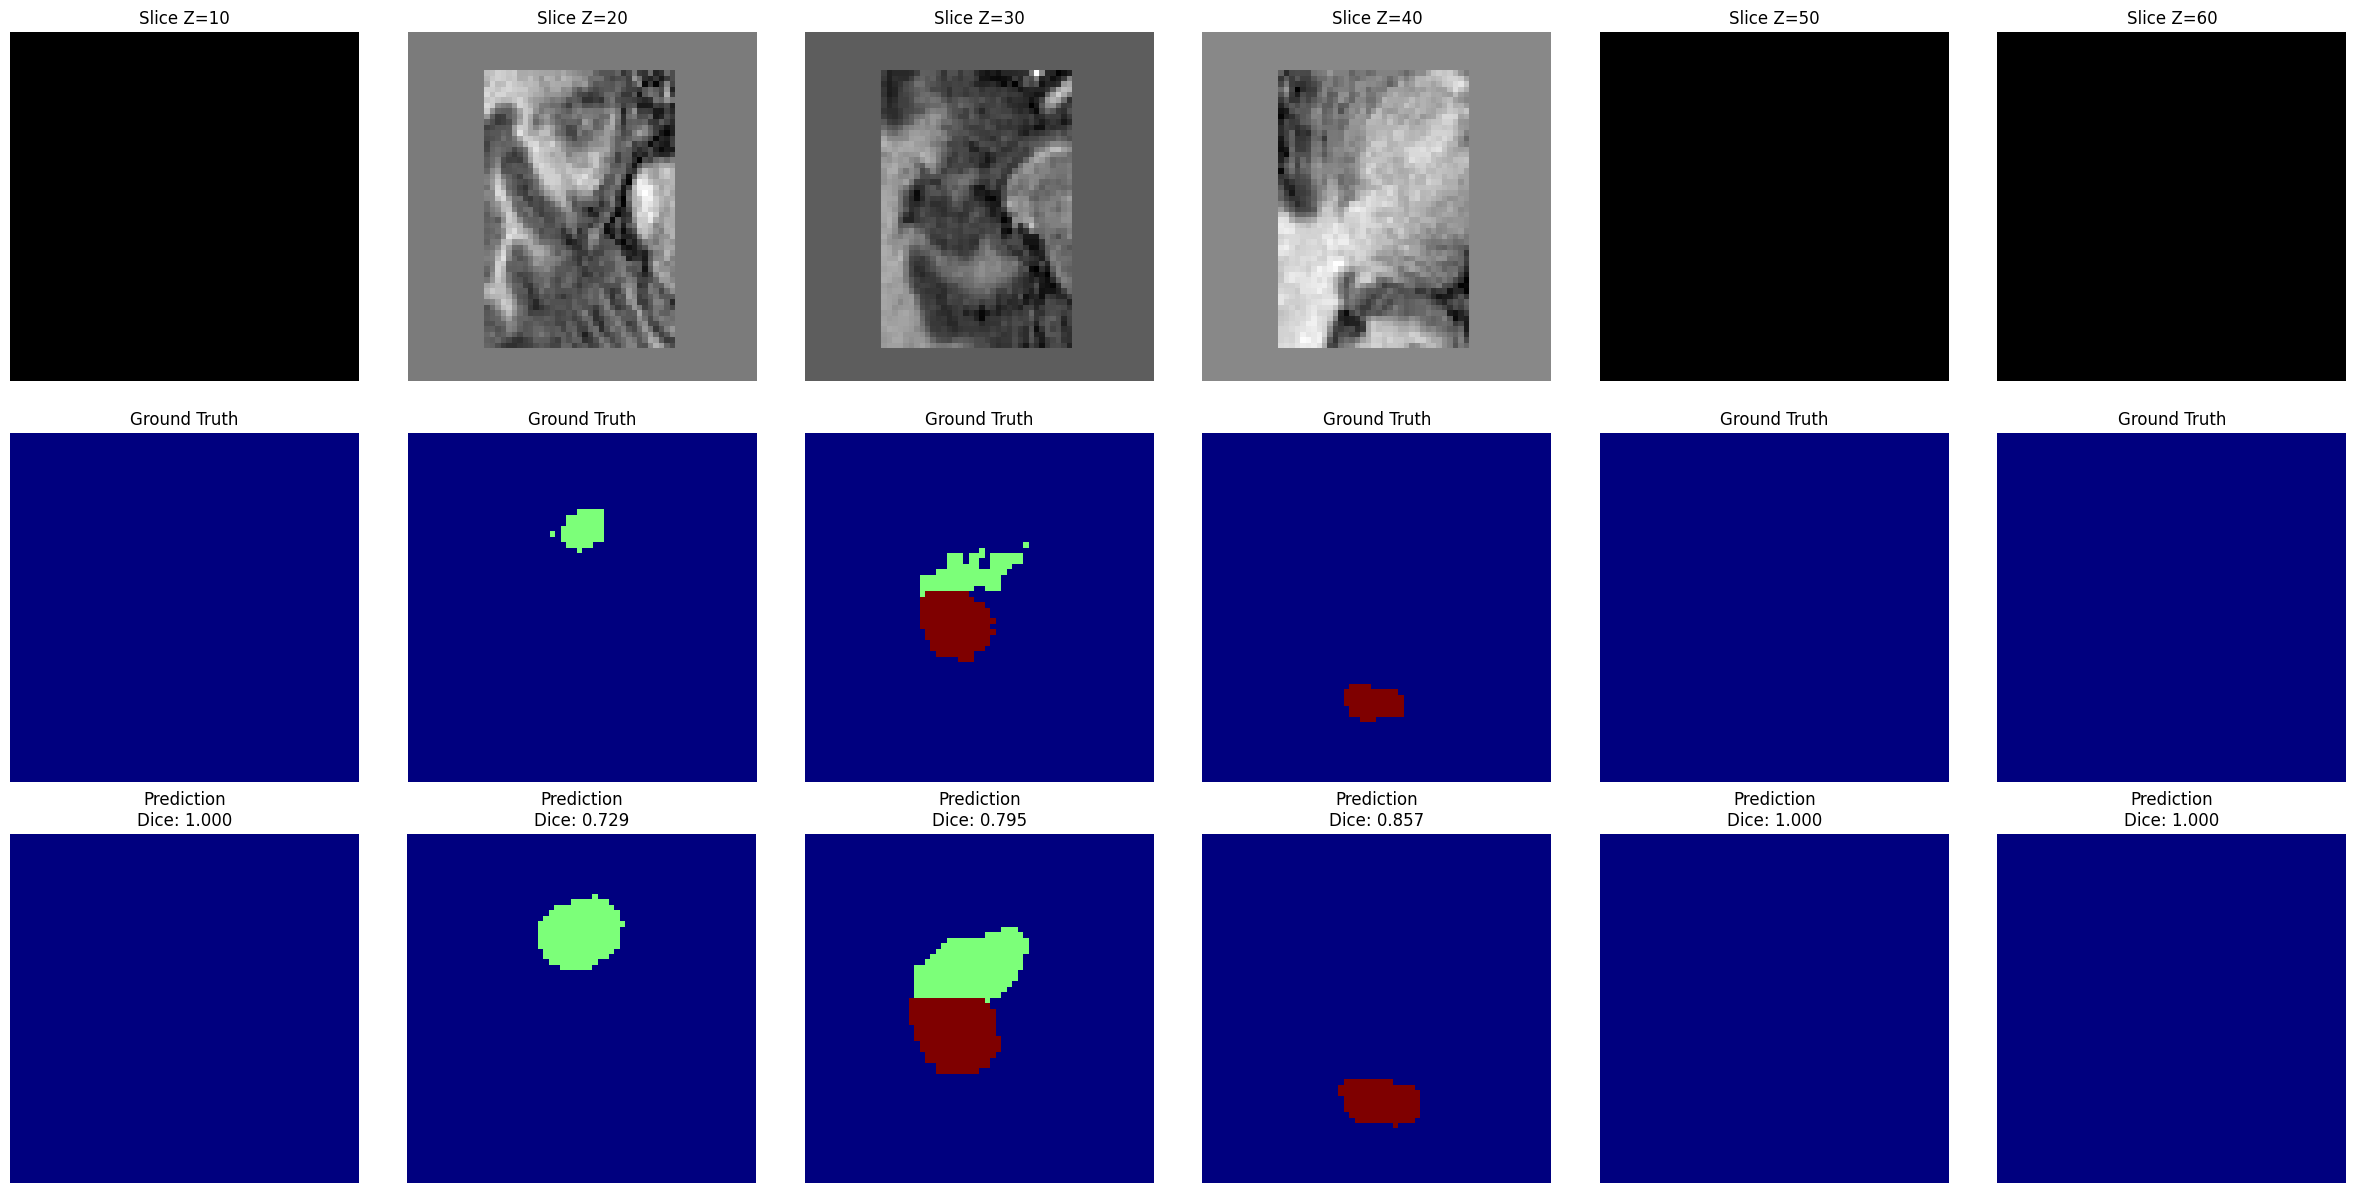

✅ Prédictions sauvegardées: predictions_3d_slices.png


In [16]:
print("\n" + "--" * 35)
print("VISUALISATION DES PRÉDICTIONS 3D")
print("--" * 35)

# Sélectionner le meilleur modèle 3D
best_3d_model = model_3d1 if dice_3d1[-1] > dice_3d2[-1] else model_3d2
best_3d_model.eval()

# Prendre un volume de validation
val_image, val_label = val_dataset_3d[0]
val_image_batch = val_image.unsqueeze(0).to(device)

# Prédiction
with torch.no_grad():
    pred_3d = best_3d_model(val_image_batch)
    pred_3d = torch.argmax(torch.softmax(pred_3d, dim=1), dim=1)[0]

# Convertir en numpy
image_np = val_image.squeeze().cpu().numpy()
label_np = val_label.cpu().numpy()
pred_np = pred_3d.cpu().numpy()

# Visualiser 6 slices à différentes profondeurs
fig, axes = plt.subplots(3, 6, figsize=(24, 12))

slice_indices = [10, 20, 30, 40, 50, 60]

for col, z_idx in enumerate(slice_indices):
    if z_idx < image_np.shape[2]:
        # Image
        axes[0, col].imshow(image_np[:, :, z_idx].T, cmap='gray', origin='lower')
        axes[0, col].set_title(f'Slice Z={z_idx}')
        axes[0, col].axis('off')
        
        # Ground Truth
        axes[1, col].imshow(label_np[:, :, z_idx].T, cmap='jet', vmin=0, vmax=2, origin='lower')
        axes[1, col].set_title('Ground Truth')
        axes[1, col].axis('off')
        
        # Prédiction
        axes[2, col].imshow(pred_np[:, :, z_idx].T, cmap='jet', vmin=0, vmax=2, origin='lower')
        
        # Calculer Dice pour cette slice
        pred_slice = pred_np[:, :, z_idx]
        gt_slice = label_np[:, :, z_idx]
        
        dice_slice = []
        for c in range(3):
            pred_c = (pred_slice == c)
            gt_c = (gt_slice == c)
            intersection = (pred_c & gt_c).sum()
            union = pred_c.sum() + gt_c.sum()
            if union > 0:
                dice_slice.append(2.0 * intersection / union)
        
        if len(dice_slice) > 0:
            axes[2, col].set_title(f'Prediction\nDice: {np.mean(dice_slice):.3f}')
        else:
            axes[2, col].set_title('Prediction')
        axes[2, col].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_3D_PATH, 'predictions_3d_slices.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Prédictions sauvegardées: predictions_3d_slices.png")